In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from arch.bootstrap import StationaryBootstrap
# from arch.bootstrap import IndependentSamplesBootstrap
# from arch.bootstrap import bootstrapped_difference
# from bootstrapped import bootstrap as bs
# from bootstrapped import compare_functions as cf
import hdbscan
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import ArrowStyle
import math
import numpy as np
import networkx as nx
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
from scipy.spatial.distance import jensenshannon
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from itertools import product

In [4]:
from utils import create_abundance_header_new, compute_cons_abun_prod, hierarchical_cluster_metabs, \
    get_metabs_clusters, avg_consumption_df, fit_ss_Ri, match_lhs_rhs_fit, \
    blindly_pred_abun_growth, fit_dynamic_Ri, compute_growth_ratio_iterate_blind_seq, \
    blindly_pred_abun_growth_seq, blindly_pred_abun_loggrowth, remove_passages, fit_dynamic_Ri_with_sim_inoc, \
    fit_dynamic_Ri_with_sim_inoc_bal, compute_Ri_dynamic_goodness_of_fit, \
    plot_panel_pred_vs_obs_abundance_blind, compute_growth_ratio_iterate_blind, \
    blindly_pred_abun_growth_without_inoc, load_data, metabs_to_remove_knockdown_species, \
    get_RMSE_Balone_func, get_B_alone_func, iterate_growth_ratio, geometric_avg, \
    get_RMSE_against_uniform_sd, random_competition_index, random_crossfeeding_index, get_competition, \
    get_crossfeeding, random_competition_subset

In [6]:
filepath_ = os.path.abspath(os.path.join('..', 'data', 'jin_pollard', \
                                    'convert_usedNames_to_jinPollardNames.csv'))
df_names_convert = pd.read_csv(filepath_, index_col=None)

In [7]:
df_speciesMetab, df_speciesAbun, \
    df_speciesAbun_super_agar, \
    df_speciesAbun_mucin, \
    df_speciesAbun_inoc, \
    df_speciesAbun_ratio, \
    df_speciesAbun_super_agar_ratio, \
    df_speciesAbun_mucin_ratio, \
    df_speciesAbun_prev, \
    df_speciesAbun_super_agar_prev, \
    df_speciesAbun_mucin_prev, \
    df_speciesAbun_next, \
    df_speciesAbun_super_agar_next, \
    df_speciesAbun_mucin_next, metab_names, \
    species_names_tmp, df_speciesMetab_prod = \
        load_data(thresh_zero=1e-8)

In [8]:
species_names = []
filepath_ = os.path.abspath(os.path.join('..', 'data', 'jin_pollard', \
                                    'convert_usedNames_to_jinPollardNames.csv'))
df_names_convert = pd.read_csv(filepath_, index_col=None)

for sp_ in range(len(species_names_tmp)):
    id_ = np.where(df_names_convert.iloc[:, 0].values == species_names_tmp[sp_])[0]
    species_names.append(df_names_convert.iloc[id_, 1].values[0])
species_names = np.array(species_names)

# set params

In [9]:
# species_names = species_names[id_species_keep]
id_species_keep = np.arange(len(species_names))

In [10]:
num_species = len(species_names)
num_metabs = len(metab_names)
num_passages = 6
num_bioRep = 1

In [11]:
date_meeting = "20231111"

In [12]:
date_ = "20231111"
distance_metric = 'euclidean'
# distance_metric = 'correlation'
metab_cluster_mean_func = 'geometric'
metab_cluster_mean_func = "linear"
clustering_method = "hdbscan"
clustering_method = "hierarch_clust"
random_seed = 635
# random_seed = 9876
# random_seed = 7360
# microcosm_type = "supernatantAgar"
# microcosm_type = "mucin"
microcosm_type = "noMicrocosm"

In [13]:
if microcosm_type == "noMicrocosm":
    df_speciesAbun_mdl = df_speciesAbun.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()
elif microcosm_type == "supernatantAgar":
    df_speciesAbun_mdl = df_speciesAbun_super_agar.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_super_agar_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_super_agar_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_super_agar_ratio.copy()
elif microcosm_type == "mucin":
    df_speciesAbun_mdl = df_speciesAbun_mucin.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_mucin_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_mucin_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_mucin_ratio.copy()

# cluster metabolites

In [14]:
# pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
# abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
# abun_avg_pass_3 = np.mean(np.log10(abun_avg_pass_3), axis=1)
# id_sp_keep = np.where(abun_avg_pass_3 >= -5)[0]
# df_speciesAbun_mdl = df_speciesAbun_mdl.iloc[id_sp_keep, :].copy()
# df_speciesAbun_prev_mdl = df_speciesAbun_prev_mdl.iloc[id_sp_keep, :].copy()
# df_speciesAbun_next_mdl = df_speciesAbun_next_mdl.iloc[id_sp_keep, :].copy()
# df_speciesAbun_ratio_mdl = df_speciesAbun_ratio_mdl.iloc[id_sp_keep, :].copy()
# df_speciesMetab = df_speciesMetab.iloc[id_sp_keep, :].copy()
# df_speciesMetab_prod = df_speciesMetab_prod.iloc[id_sp_keep, :].copy()
# df_speciesAbun_inoc = df_speciesAbun_inoc.iloc[id_sp_keep, :].copy()
id_sp_keep = np.arange(df_speciesAbun_mdl.shape[0])

In [15]:
nclusts = 10
df_metabs_clusters, df_speciesMetab_new, df_speciesMetab_prod_new = \
    get_metabs_clusters(df_speciesMetab.copy(), df_speciesMetab_prod.copy(), \
                        bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=nclusts, distance_metric="euclidean", \
                        method_cluster="ward", normalize_=False)
df_speciesMetab_cluster, df_speciesMetab_prod_cluster = \
    avg_consumption_df(df_speciesMetab_new, df_speciesMetab_prod_new, df_metabs_clusters, \
                       metab_cluster_mean_func="geometric")

In [16]:
df_metabs_clusters_unnorm = df_metabs_clusters.copy()

In [17]:
metab_cluster_names = []
for m_ in range(df_speciesMetab_cluster.shape[1]):
    metab_cluster_names.append(f'{m_ + 1}')

In [18]:
df_speciesMetab_cluster_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_cluster.columns = metab_cluster_names
# len(metab_cluster_names)

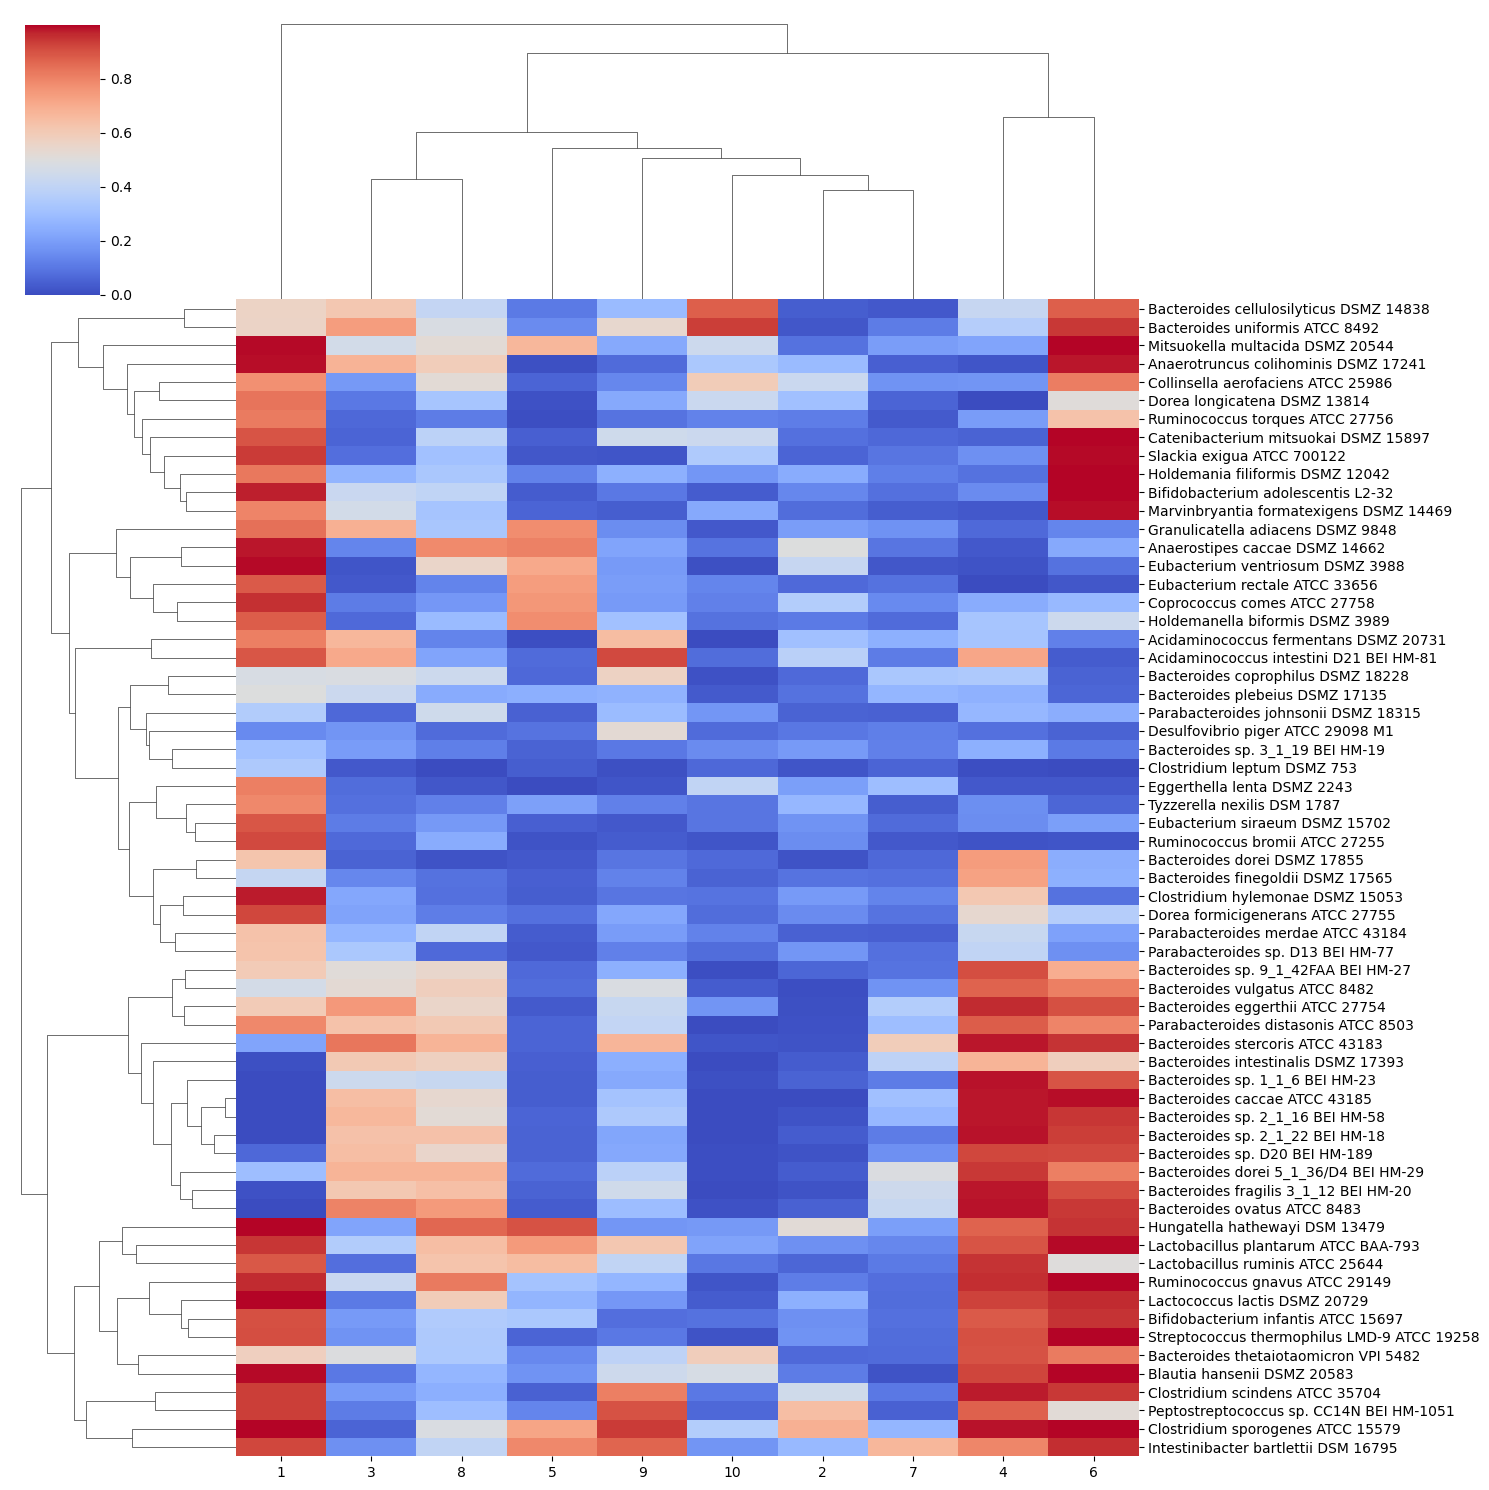

In [19]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

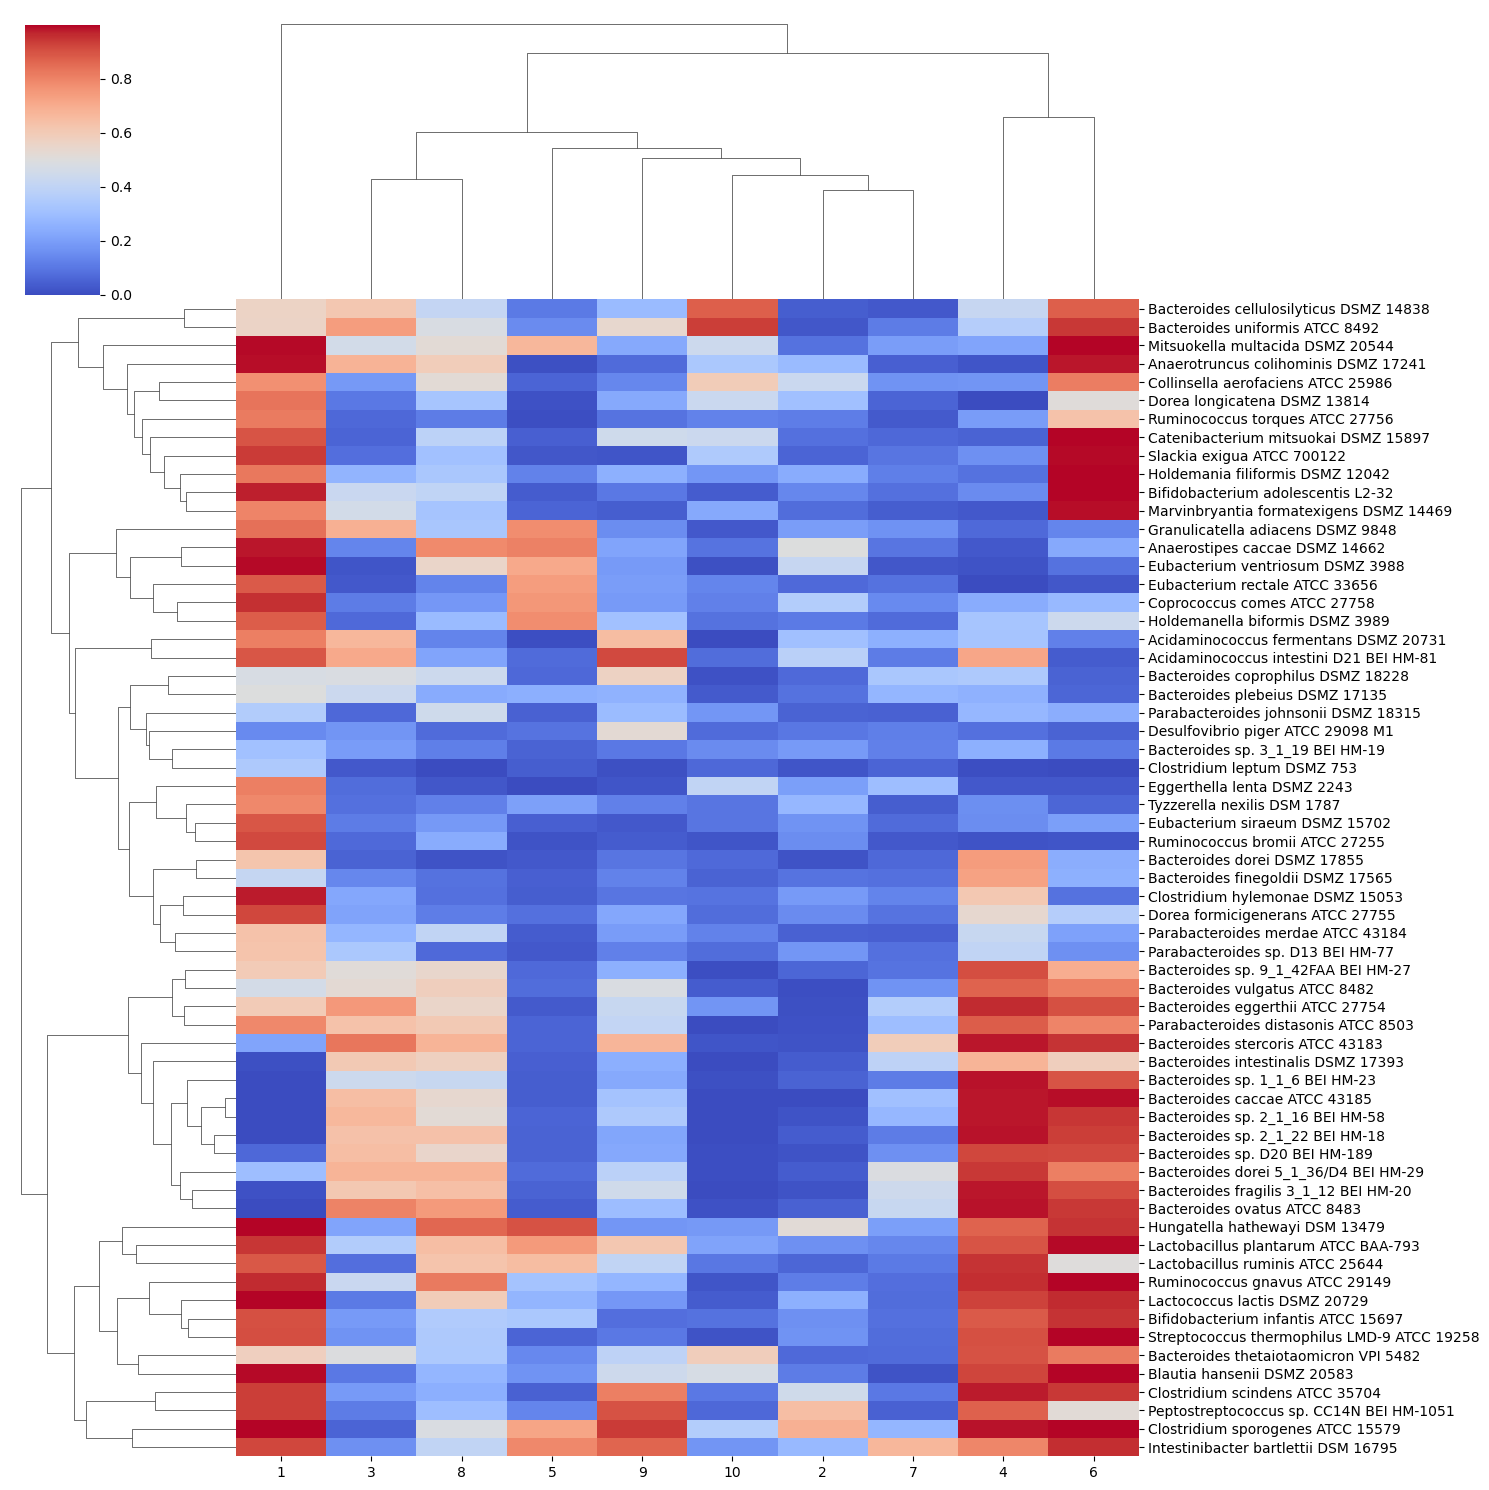

In [20]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

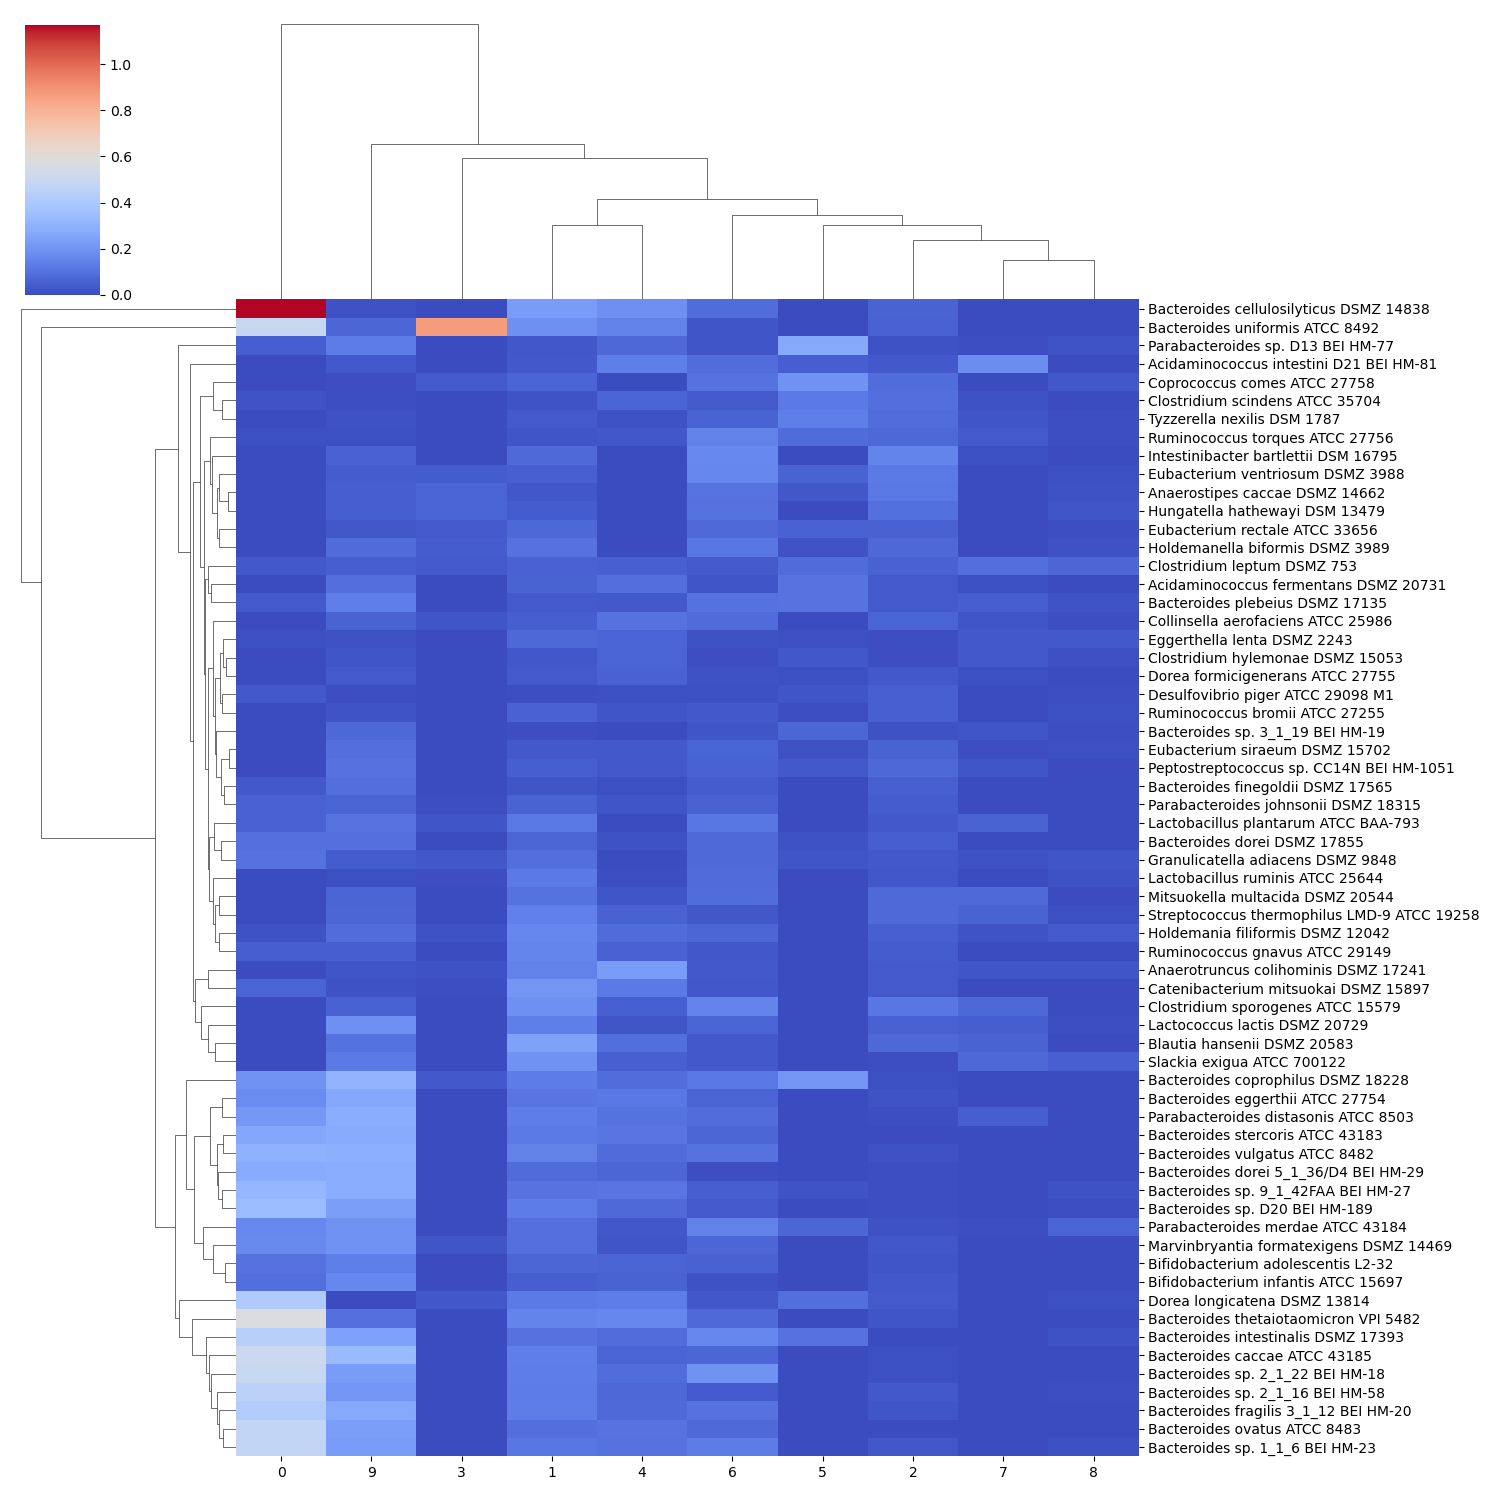

In [21]:
df_tmp = df_speciesMetab_prod_cluster.copy()
for col_ in df_tmp.columns.values:
    df_tmp[col_] = np.log10(1 + df_tmp[col_].values)
plt_ = sns.clustermap(df_tmp.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

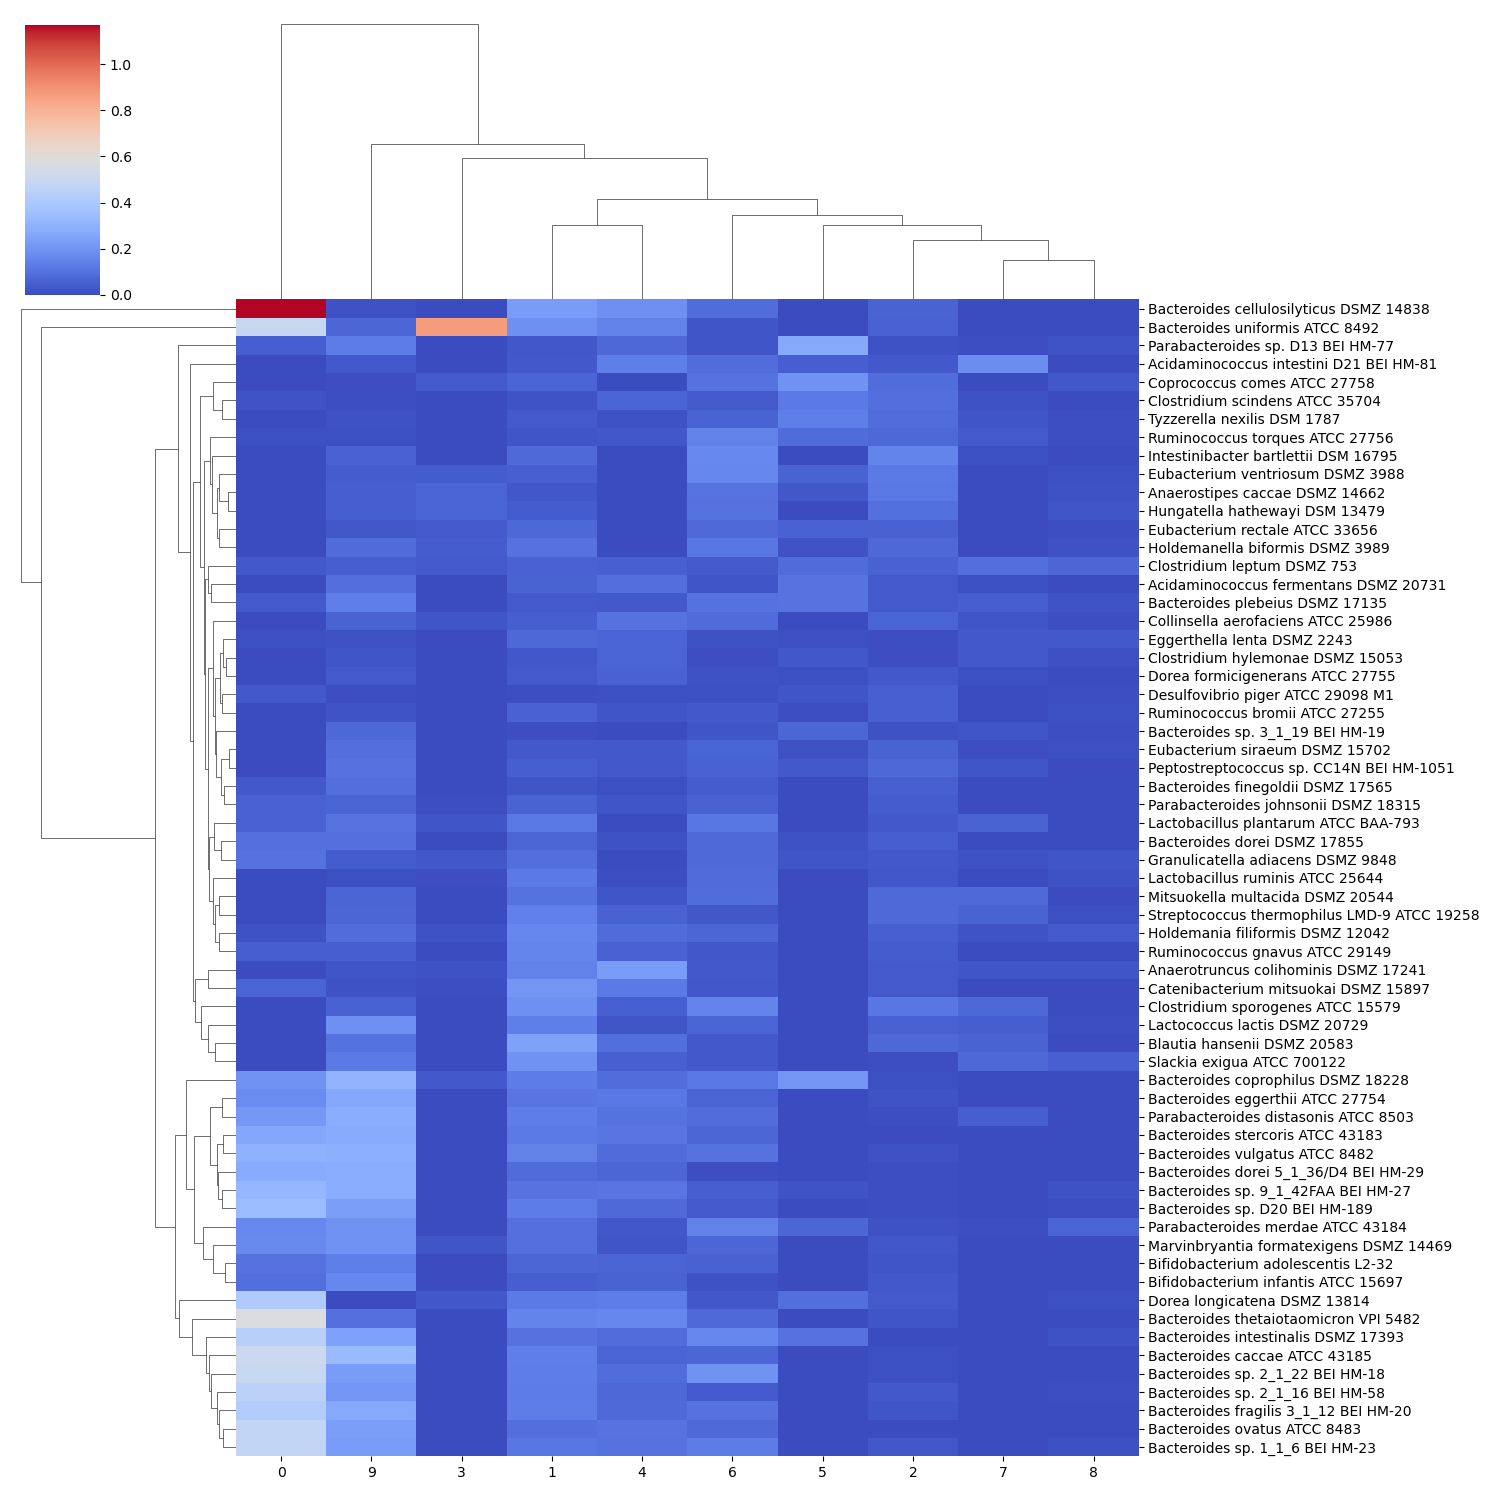

In [22]:
df_tmp = df_speciesMetab_prod_cluster.copy()
for col_ in df_tmp.columns.values:
    df_tmp[col_] = np.log10(1 + df_tmp[col_].values)
plt_ = sns.clustermap(df_tmp.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

In [23]:
df_metabs_clusters.iloc[92, :]
# df_metabs_clusters.shape

cluster_labels                         92
cluster_counts                          1
cluster_metab_IDs                   [218]
cluser_metab_names    [PYROGLUTAMIC ACID]
Name: 92, dtype: object

In [24]:
df_speciesAbun_sim = pd.DataFrame()
header_new = create_abundance_header_new(num_bioRep=3, num_passages=7)
count_ = 0
for rep_ in np.arange(1):
    for pass_ in np.arange(7):
        if pass_ == 0:
            df_speciesAbun_sim[header_new[count_]] = (1 / num_species) * np.ones(num_species)
#             df_speciesAbun_sim[header_new[count_]] = \
#                 df_speciesAbun_inoc.iloc[:, 0].values
        else:
            df_speciesAbun_sim[header_new[count_]] = \
                df_speciesAbun_mdl.iloc[:, (pass_ - 1) + 6 * rep_].values
        count_ += 1

In [25]:
df_speciesAbun_ratio_sim = pd.DataFrame()
df_speciesAbun_prev_sim = pd.DataFrame()
df_speciesAbun_next_sim = pd.DataFrame()
count_ = 0
num_bioRep = 3
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7'])
reps_ = np.array(['r0'])
brep_vec = list(range(num_bioRep))
thresh_zero = 1e-8
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_

        df_speciesAbun_prev_sim[col_2] = df_speciesAbun_sim[col_1].values
        df_speciesAbun_next_sim[col_2] = df_speciesAbun_sim[col_2].values

        array_1 = np.array(df_speciesAbun_sim[col_2].values / df_speciesAbun_sim[col_1].values)
        array_2 = np.array(df_speciesAbun_sim[col_2].values)
        array_3 = np.array(df_speciesAbun_sim[col_1].values)
        df_speciesAbun_ratio_sim[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]

        if len(id_) > 0:
            df_speciesAbun_ratio_sim.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                abun_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun_sim[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun_sim[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        abun_alt_ratio.append(val_2 / val_1)

        count_ += 1

In [34]:
pass_keep = 2
abun_avg_pass_3 = np.array(df_speciesAbun_sim.iloc[:, 3])
# abun_avg_pass_3 = 10**np.mean(np.log10(abun_avg_pass_3), axis=1)

In [36]:
species_names_abbr = []
for species_ in species_names:
    tmp = species_.split("-")
    out_ = f'{tmp[0][:1]}. {tmp[1]}'
    species_names_abbr.append(out_)
species_names_abbr[7] = f'{species_names_abbr[7]} 5-1-36-D4'
species_names_abbr[8] = f'{species_names_abbr[8]} DSM-17855'
species_names_abbr[11] = f'{species_names_abbr[11]} 3-1-12'
species_names_abbr[16] = f'{species_names_abbr[16]} 2-1-16'
species_names_abbr[17] = f'{species_names_abbr[17]} 2-1-22'
species_names_abbr[18] = f'{species_names_abbr[18]} 3-1-19'
species_names_abbr[19] = f'{species_names_abbr[19]} 9-1-42FAA'
species_names_abbr[20] = f'{species_names_abbr[20]} D2'
species_names_abbr[55] = f'{species_names_abbr[55]} D13'
species_names_abbr[56] = f'{species_names_abbr[56]} CC14N-HM-1051'
species_names_abbr = np.array(species_names_abbr, dtype=object)

In [37]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20231111'
date_meeting = '20231111'

n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
num_passages = 7
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + \
    list(pass_keep + 2 * (num_passages - 1))
pass_rm = [0, 2, 3, 4, 5]
Ri_dynamic_obj, A_train, b_train = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_sim, \
                                df_speciesAbun_next_sim, \
                                df_speciesAbun_ratio_sim, p_vec_new, \
                                file_save, num_passages=6, pass_rm=pass_rm, num_brep=1, \
                                get_prod=True, B_alone=0.1, \
                                df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                prod_use_prev=False, use_dilution_term=True, \
                                dilution_factor=15000, use_avg_for_prod=False, \
                                return_raw_data=True, check_ratio_dir=False)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.001
count = 1, p_tmp = 0.01
count = 2, p_tmp = 0.05
count = 3, p_tmp = 0.06
count = 4, p_tmp = 0.07
count = 5, p_tmp = 0.08
count = 6, p_tmp = 0.09
count = 7, p_tmp = 0.1
count = 8, p_tmp = 0.125
count = 9, p_tmp = 0.15
count = 10, p_tmp = 0.175
count = 11, p_tmp = 0.2
count = 12, p_tmp = 0.3
count = 13, p_tmp = 0.4
count = 14, p_tmp = 0.5
count = 15, p_tmp = 0.55
count = 16, p_tmp = 0.6
count = 17, p_tmp = 0.65
count = 18, p_tmp = 0.7


In [38]:
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy()

count_p = 7
Ri_0_init_new = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

In [40]:
# fit Ri with production and iteratively find B_alone
num_iter = 100
B_alone_iter = {}

## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20231111'
date_meeting = '20231111'


rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new_tmp = [p_vec_new[count_p]]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'_iterate_Balone.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
num_passages = 7
pass_keep = np.arange(num_passages - 1)
# id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
id_keep = list(pass_keep)
pass_rm = [0, 2, 3, 4, 5]

RMSE_Balone_iterate = {}
id_species_keep = np.arange(df_speciesAbun_mdl.shape[0])

for iter_ in range(num_iter):
    print(f'iteration = {iter_}')
    if iter_ == 0:
#         B_alone_cur = np.median(abun_alone)
        Ri_avg = Ri_0_init_new.copy()
        B_alone_cur = get_B_alone_func(Ri_avg, \
                                       df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
#         B_alone_cur = 0.1 * np.ones(num_species)
    else:
        Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
        B_alone_cur = B_alone_iter[iter_ - 1].copy()
    
    
    Ri_dynamic_obj, A_train, b_train = fit_dynamic_Ri(df_speciesMetab_tmp.iloc[id_species_keep, :], \
                                    df_speciesAbun_prev_sim.iloc[:, id_keep], \
                                    df_speciesAbun_next_sim.iloc[:, id_keep], \
                                    df_speciesAbun_ratio_sim.iloc[:, id_keep], p_vec_new_tmp, \
                                    file_save, num_passages=6, pass_rm=pass_rm, save_data=False, \
                                    num_brep=1, \
                                    get_prod=True, B_alone=B_alone_cur, \
                                    df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                                    prod_use_prev=False, use_avg_for_prod=False, \
                                    return_raw_data=True, check_ratio_dir=False)
    Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'][0].copy()
#     a_tmp, A_mat, b_vec = fit_dynamic_Ri(df_speciesMetab_tmp, \
#                                     df_speciesAbun_prev_sim.iloc[:, id_keep], \
#                                     df_speciesAbun_next_sim.iloc[:, id_keep], \
#                                     df_speciesAbun_ratio_sim.iloc[:, id_keep], p_vec_new_tmp, \
#                                     file_save, num_passages=6, pass_rm=pass_rm, save_data=False, \
#                                     num_brep=3, \
#                                     get_prod=False, B_alone=B_alone_cur, \
#                                     df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
#                                     prod_use_prev=False, use_avg_for_prod=True, \
#                                     return_raw_data=True, check_ratio_dir=False, \
#                                         mode_Ri=False, Ri=Ri_avg.copy())
    
#     abun_alone_tmp = np.zeros((num_species))

#     for species_ in range(num_species):
#         abun_alone_tmp[species_] = np.sum(Ri_avg[0] * np.array(df_speciesMetab_cluster.iloc[species_, :].values))
    B_alone_iter[iter_] = get_B_alone_func(Ri_avg, \
                                           df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
#     B_alone_iter[iter_] = 1 / (a_tmp['Ri_noMicrocosm_dynamicAll_fit_joint'][0] + 1e-10)
    RMSE_Balone_iterate[iter_] = \
        get_RMSE_Balone_func(df_speciesMetab_cluster.iloc[id_species_keep, :], \
                             df_speciesMetab_prod_cluster.iloc[id_species_keep, :], \
                             p_vec_new_tmp, 0, \
                        Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy(), \
                        df_speciesAbun_inoc.iloc[id_species_keep, :], \
                             df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
                        df_speciesAbun_ratio_mdl, B_alone_cur, num_passages=6, \
                        use_dilution=True)
Ri_dynamic_obj['B_alone_iter'] = B_alone_iter
with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

iteration = 0
count = 0, p_tmp = 0.1
iteration = 1
count = 0, p_tmp = 0.1
iteration = 2
count = 0, p_tmp = 0.1
iteration = 3
count = 0, p_tmp = 0.1
iteration = 4
count = 0, p_tmp = 0.1
iteration = 5
count = 0, p_tmp = 0.1
iteration = 6
count = 0, p_tmp = 0.1
iteration = 7
count = 0, p_tmp = 0.1
iteration = 8
count = 0, p_tmp = 0.1
iteration = 9
count = 0, p_tmp = 0.1
iteration = 10
count = 0, p_tmp = 0.1
iteration = 11
count = 0, p_tmp = 0.1
iteration = 12
count = 0, p_tmp = 0.1
iteration = 13
count = 0, p_tmp = 0.1
iteration = 14
count = 0, p_tmp = 0.1
iteration = 15
count = 0, p_tmp = 0.1
iteration = 16
count = 0, p_tmp = 0.1
iteration = 17
count = 0, p_tmp = 0.1
iteration = 18
count = 0, p_tmp = 0.1
iteration = 19
count = 0, p_tmp = 0.1
iteration = 20
count = 0, p_tmp = 0.1
iteration = 21
count = 0, p_tmp = 0.1
iteration = 22
count = 0, p_tmp = 0.1
iteration = 23
count = 0, p_tmp = 0.1
iteration = 24
count = 0, p_tmp = 0.1
iteration = 25
count = 0, p_tmp = 0.1
iteration = 26
count =

In [41]:
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']
B_alone_iter = Ri_dynamic_obj['B_alone_iter']

In [42]:
# evalute Ri with production and iterative Balone
date_ = '20231111'
date_meeting = '20231111'

num_iter = 100
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
count_p = 7
# num_iter = 20
p_vec_new_tmp = [p_vec_new[count_p]]
count_p = 0

RMSE_mat_full = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# Ri_fit = {0: Ri_pass1.copy()}
# Ri_0 = {0: Ri_inoc.copy()}
abun_alone = get_B_alone_func(Ri_avg, df_speciesMetab_cluster.iloc[id_species_keep, :].copy())
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all_prod, RMSE_obj_all_prod = \
    blindly_pred_abun_growth([p_vec_new_tmp[count_p]], \
                             df_speciesMetab_tmp.iloc[id_species_keep, :], \
                             df_speciesAbun_inoc.iloc[id_species_keep, :].copy(), \
                             df_speciesAbun_mdl.copy(), \
                             df_speciesAbun_prev_mdl.copy(), \
                             df_speciesAbun_ratio_mdl.copy(), \
                             Ri_fit.copy(), "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=True, B_alone=B_alone_iter[num_iter - 2].copy(), \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp.iloc[id_species_keep, :], \
                             prod_use_prev=False, use_dilution=True, dilution_factor=15000, \
                             use_avg_for_prod=False, Ri_0=None)
for pass_ in range(num_passages - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all_prod[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all_prod[pass_]["growth_ratio"]

In [53]:
id_species = np.arange(num_species) * 3
y = sens_obj_all_prod[2]['df_speciesAbun_next_pred'][id_species].copy()
y[y <= 1e-8] = 1e-8
y /= np.sum(y)
x = abun_avg_pass_3.copy()
RMSE_ = np.sqrt(np.mean(np.power(np.log10(x) - np.log10(y), 2.0)))

In [54]:
RMSE_

1.7884068958519905

In [52]:
np.sum(y)

0.9999999999999998